# Ermine Tutorial 03
## Training hidden Markov models on single-particle tracking data with ermine

by Sebastian Malkusch (c) 2021  
malkusch@med.uni-frankfurt.de  
Data Science| Klinische Pharmakologie  
Institut für Klinische Pharmakologie  
Goethe - Universität  
Theodor-Stern-Kai 7  
60590 Frankfurt am Main

## Abstract
In this tutorial, we will build a hidden Markov model that describes the probability density distribution of jump widths and learns the inter-mode transition probabilities by analyzing the temporal sequence of jump distances. 

## Prerequisite
* Tutorial 01 must be completed
* The file Fab_CS6_cell20_jumps.csv needs to be saved in folder results
* Tutorial 02 must be completed
* The optimal number of mobility modes must be known

## Import libraries
You need to install Ermine prior to usage.  
Run  
python -m pip install pyErmine  
from the command line  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import ermine as em
from matplotlib import pyplot as plt

## Import Jump_df
Store the path to the jump data set in the variable "file_name"
The routine imports the jump data to a data frame (data_df).

In [2]:
file_name = "results/Fab_CS6_cell20_jumps.csv"
data_df = pd.read_csv(filepath_or_buffer = file_name)
data_df.head()

,Unnamed: 0,id_departure,frame_departure,x [nm]_departure,y [nm]_departure,sigma [nm]_departure,intensity [photon]_departure,offset [photon]_departure,bkgstd [photon]_departure,uncertainty_xy [nm]_departure,...,seg.id_destination,seg.loc_count_destination,seg.track_pos_destination,track.noise_destination,track.t_start_destination,track.lifetime_destination,track.id_destination,track.loc_count_destination,track.seg_count_destination,jump_distance
0,0,149,1,31496.6,32117.6,167.4,665.8,34.8,9.3,22.5,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,13.285330
1,1,357,2,31489.3,32106.5,168.6,916.5,33.0,10.8,19.2,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,7.964923
2,2,570,3,31496.3,32110.3,151.3,860.2,38.8,8.0,14.1,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,50.420631
3,3,783,4,31470.3,32067.1,182.5,594.9,32.0,7.3,24.0,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,26.654268
4,4,996,5,31472.0,32093.7,182.9,630.6,31.6,9.5,27.6,...,1.0,9.0,0.0,0.0,1.0,8.0,1.0,9.0,1.0,57.015437


## Define experimental parameters
* Define mobility modes for the model: priorModel_components  
* Define time interval between two measurements : $\tau$  
* Define degrees of freedom for translational movement: dof

In [3]:
priorModel_components = 3 # estimated in Tutorial 02
tau = 0.02
dof = 4

## Initial parameter estimation
Parameterize a jump-distance mixtrue model by training with the jump distance sequence.
Store the optimized model parameters to initModel_diffusion_coefficients and initModel_weights. The seed is needed for a repruducible initialization step.

In [4]:
seed = 42
np.random.seed(seed)
x_jmm = data_df["jump_distance"].values
jmm = em.JumpDistanceMixtureModel(n_components = priorModel_components,
                                  degrees_of_freedom = dof,
                                  tau = tau,
                                  init_params = "wm", # here weights and expected mean squared displacements are initialized!
                                  params = "wm") # here weights and expected mean squared displacements are optimized!
jmm.fit(x_jmm)
print("done.")

done.


## Store initial model parameters into varaibles

In [5]:
initModel_components = jmm.n_components
initModel_diffusion_coefficients = jmm.diffusion_coefficients() #Notice the brackets!
initModel_weights = jmm.weights
initModel_trans_mat = em.init_transition_matrix(n_components = initModel_components, stability = 0.9)
print("done")

done


## Set up HMM from initial model parameters
Note that init_params is an empty string. This tells the class not to initialize the model parameters itself, but to take the initial parameters specified by the user.

In [6]:
hmm = em.ErmineHMM(n_components = priorModel_components,
                   diffusion_degrees_of_freedom = dof,
                   tau = tau,
                   init_params = "", # do not estimate initial model parameters
                   params="std",
                   n_iter = 1000,
                   tol = 1e-5)
hmm.startprob_ = initModel_weights
hmm.transmat_ = initModel_trans_mat
hmm.diffusion_coefficients_ = initModel_diffusion_coefficients
print("done")

done


## Create observation sequence
An observation sequence with multiple trajectories is created for training: x_hmm  
The respective trajectory lengths are stored separately: lengths

In [7]:
x_hmm, lengths = em.create_observation_sequence(data_df)
print("done")

done


## Train HMM
Parameterize the HMM with the observation sequence.  
This procedure is time consuming, maybe grab a coffe.

In [8]:
hmm.fit(x_hmm, lengths)
optModel_startprob = hmm.startprob_
optModel_transition_probabilities = hmm.transmat_
optModel_diffusion_coefficients = hmm.diffusion_coefficients_
optModel_transition_probabilities

done


## Evaluate HMM quality

In [9]:
pd.DataFrame(hmm.evaluate(x_hmm, lengths))

,classes,tracks,dof,instances,log_likelihood,BIC,AIC,AICc
0,3,1,11,130621,-672717.204189,1.345564e+06,1.345456e+06,1.345456e+06


## Determine the equilibrium mode distribution
Train a jump-distance mixed model with the jump data, optimizing only the weight parameter and keeping the expected mean squared displacements on the values determined by the HMM.

In [10]:
seed = 42
np.random.seed(seed)
jmm = em.JumpDistanceMixtureModel(n_components=priorModel_components,
                                  degrees_of_freedom = dof,
                                  tau=tau,
                                  init_params = "", #Notice, are neither initializing the weights nor the diffusion coefficients.
                                  params="w") #Notice, only the weights are optimized, diffusion is kept fix!

# Since neither the weights nor the diffusion coefficients are initialized, we have to enter them manually.
jmm.mu = em.postprocessing.calculate_expectation_value(diff_coeff = optModel_diffusion_coefficients,
                                                       tau = tau,
                                                       dof = dof,
                                                       sigma = 0, # We do not expect any errors in this tutorial
                                                       epsilon = 0)# We do not expect any errors in this tutorial
jmm.weights = optModel_startprob

jmm.fit(x_jmm)
optModel_weights = jmm._weights
print("done")

done


## Plot optimal model
Plot the optimal model and superimpose it to the pdf of the original jumpdistance distribution.

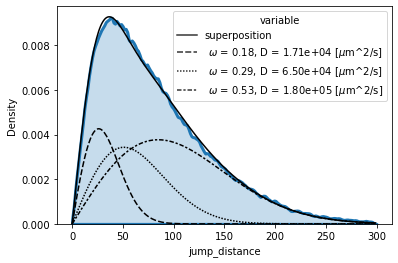

In [11]:
model_df = pd.DataFrame({"r": np.arange(0,300,1),
                        "superposition": np.zeros(300)})
for i in np.arange(0, priorModel_components, 1):
    unimodal_judi_model = em.JumpDistanceModel(diffusion_coefficient = optModel_diffusion_coefficients[i],
                                               degrees_of_freedom = 4,
                                               tau=0.02)
    component_string = str(" $\\omega$ = %.2f, D = %.2e [$\\mu$m^2/s]" %(optModel_weights[i], optModel_diffusion_coefficients[i]))
    model_df[component_string] = optModel_weights[i] * unimodal_judi_model.pdf(distance = model_df["r"])
    model_df["superposition"] = model_df["superposition"] + model_df[component_string]

sns.kdeplot(data=data_df, x="jump_distance", fill = True, bw_adjust = 0.25, linewidth = 3, clip = [0, 300])
sns.lineplot(data=model_df.melt(id_vars=['r']), x="r", y="value", color="black", style="variable")
plt.show()